In [3]:
# load required modules and dataset

import kagglehub, os, tensorflow, keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Download latest version
dataset_path = kagglehub.dataset_download("sujansarkar/isic-2017-preprocessed-augmented")
# print("Path to dataset files:", dataset_path)
data_dir = os.path.join(dataset_path, "content/Linear_Exact_Aug")

# Loading the datasets

In [4]:
# load the dataset => training, cross-validation and test sets

train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")
valid_dir = os.path.join(data_dir, "Valid")

# print("Train Directory:", train_dir)
# print("Test Directory:", test_dir)
# print("Validation Directory:", valid_dir)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 14018 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# CNN Model (DenseNet201 Architecture)

In [5]:
# Load VGG19 without the top layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers to save memory
for layer in base_model.layers[:100]: 
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add Fully Connected Layers with Dropout
x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = LeakyReLU(negative_slope=0.02)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, kernel_regularizer=l2(0.001))(x)
x = LeakyReLU(negative_slope=0.02)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Output Layer
x = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=x)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Model Summary

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 18,830,915 (71.83 MB)

 Trainable params: 17,792,771 (67.87 MB)

 Non-trainable params: 1,038,144 (3.96 MB)

## Model Compilation, Learning Rate Scheduler and Model Checkpoints

In [7]:
# compiling the model
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler: Reduce LR if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# setting checkpoint for the optimal weights corresponding to the minimum loss
checkpoint = ModelCheckpoint("best_densenet201.weights.h5", monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min", verbose=1)

# Early Stopping: Stop training if val_loss doesn't improve for 5 epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Fitting the Model

In [8]:
# fitting the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 30,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6070 - loss: 1.4564
Epoch 1: val_loss improved from inf to 1.04218, saving model to best_densenet201.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 661s 808ms/step - accuracy: 0.6072 - loss: 1.4559 - val_accuracy: 0.7267 - val_loss: 1.0422 - learning_rate: 1.0000e-04
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8104 - loss: 0.8523
Epoch 2: val_loss improved from 1.04218 to 0.87039, saving model to best_densenet201.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 113s 255ms/step - accuracy: 0.8104 - loss: 0.8522 - val_accuracy: 0.7867 - val_loss: 0.8704 - learning_rate: 1.0000e-04
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9155 - loss: 0.5886
Epoch 3: val_loss did not improve from 0.87039
439/439 ━━━━━━━━━━━━━━━━━━━━ 110s 249ms/step - accuracy: 0.9155 - loss: 0.5885 - val_accuracy: 0.7600 - val_loss: 0.9066 - learning_rate: 1.0000e-04
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy:

# Loading the Optimized weights

In [9]:
# Load and display the optimized weights

# Load best weights
model.load_weights("best_densenet201.weights.h5")

# Get all layer weights as a list of NumPy arrays
optimized_weights = model.get_weights()

# Print weight values for each layer
'''for i, weight in enumerate(optimized_weights):
    print(f"Weight {i+1}: Shape = {weight.shape}")
    print(weight)
    print("\n" + "-"*50)***
'''

'for i, weight in enumerate(optimized_weights):\n    print(f"Weight {i+1}: Shape = {weight.shape}")\n    print(weight)\n    print("\n" + "-"*50)***\n'

# Accuracy and Correct Prediction Percentages on Validation dataset

In [12]:
# validation loss and validation accurracy
from sklearn.metrics import accuracy_score
import numpy as np

class_map = {0: "melanoma", 1: "nevus", 2:"seborrheic-keratosis"}

# Model evaluation
validation_loss, validation_accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation loss: {validation_loss:.4f}")


# Model predictions
valid_generator.shuffle = False
predictions = model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_generator.classes
test_length = len(true_classes)

# Print predicted classes on validation set
print("Predicted vs True Classes:")
for i in range(test_length):
    print(f"Sample {i+1:<3}: Predicted = {class_map[predicted_classes[i]]:<25} True = {class_map[true_classes[i]]:<25}")

# individual percentage of correctly predicted classes
mel, nev, seb = 0, 0, 0
for i in range(test_length):
    mel += (true_classes[i] == 0)
    nev += (true_classes[i] == 1)
    seb += (true_classes[i] == 2)

print(mel, nev, seb)

correct_mel, correct_nev, correct_seb = 0, 0, 0

for i in range(mel):
    correct_mel += (predicted_classes[i] == 0)

for i in range(mel, mel+nev):
    correct_nev += (predicted_classes[i] == 1)

for i in range(mel+nev, test_length):
    correct_seb += (predicted_classes[i] == 2)

print("Correctly predicted melanoma: ", (correct_mel / mel) * 100, "%")
print("Correctly predicted nevus: ", (correct_nev / nev) * 100, "%")
print("Correctly predicted seborrheic-keratosis: ", (correct_seb / seb) * 100, "%")


# Computing correct prediction percentage
accuracy = accuracy_score(true_classes, predicted_classes) * 100
print(f"Correct Prediction Percentage: {accuracy:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7611 - loss: 1.0009
Validation Accuracy: 80.67%
Validation loss: 0.8168
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Predicted vs True Classes:
Sample 1  : Predicted = nevus                     True = melanoma                 
Sample 2  : Predicted = melanoma                  True = melanoma                 
Sample 3  : Predicted = nevus                     True = melanoma                 
Sample 4  : Predicted = nevus                     True = melanoma                 
Sample 5  : Predicted = melanoma                  True = melanoma                 
Sample 6  : Predicted = melanoma                  True = melanoma                 
Sample 7  : Predicted = melanoma                  True = melanoma                 
Sample 8  : Predicted = melanoma                  True = melanoma                 
Sample 9  : Predicted = melanoma                  True = melanoma                 
Sample 10 : Predicted = seborrheic-keratosis      True = melan

# Accuracy and Correct Prediction Percentages on Test Dataset

In [18]:
# test loss and test accurracy
from sklearn.metrics import accuracy_score
import numpy as np

class_map = {0: "melanoma", 1: "nevus", 2:"seborrheic-keratosis"}

# Model evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")


# Model predictions
test_generator.shuffle = True
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
test_length = len(true_classes)

# Print predicted classes on the test dataset
print("Predicted vs True Classes:")
for i in range(test_length):
    print(f"Sample {i+1:<3}: Predicted = {class_map[predicted_classes[i]]:<25} True = {class_map[true_classes[i]]:<25}")

# individual percentage of correctly predicted classes
mel, nev, seb = 0, 0, 0
for i in range(test_length):
    mel += (true_classes[i] == 0)
    nev += (true_classes[i] == 1)
    seb += (true_classes[i] == 2)

print(mel, nev, seb)

correct_mel, correct_nev, correct_seb = 0, 0, 0

for i in range(mel):
    correct_mel += (predicted_classes[i] == 0)

for i in range(mel, mel+nev):
    correct_nev += (predicted_classes[i] == 1)

for i in range(mel+nev, test_length):
    correct_seb += (predicted_classes[i] == 2)

print("Correctly predicted melanoma: ", (correct_mel / mel) * 100, "%")
print("Correctly predicted nevus: ", (correct_nev / nev) * 100, "%")
print("Correctly predicted seborrheic-keratosis: ", (correct_seb / seb) * 100, "%")


# Computing correct prediction percentage
accuracy = accuracy_score(true_classes, predicted_classes) * 100
print(f"Correct Prediction Percentage: {accuracy:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7224 - loss: 1.3965
Test Accuracy: 78.33%
Test loss: 1.0574
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
Predicted vs True Classes:
Sample 1  : Predicted = nevus                     True = melanoma                 
Sample 2  : Predicted = nevus                     True = melanoma                 
Sample 3  : Predicted = melanoma                  True = melanoma                 
Sample 4  : Predicted = seborrheic-keratosis      True = melanoma                 
Sample 5  : Predicted = melanoma                  True = melanoma                 
Sample 6  : Predicted = nevus                     True = melanoma                 
Sample 7  : Predicted = melanoma                  True = melanoma                 
Sample 8  : Predicted = nevus                     True = melanoma                 
Sample 9  : Predicted = nevus                     True = melanoma                 
Sample 10 : Predicted = seborrheic-keratosis      True = melanoma     

# Scatterplot and regions marked by Classifier with Decision Boundaries

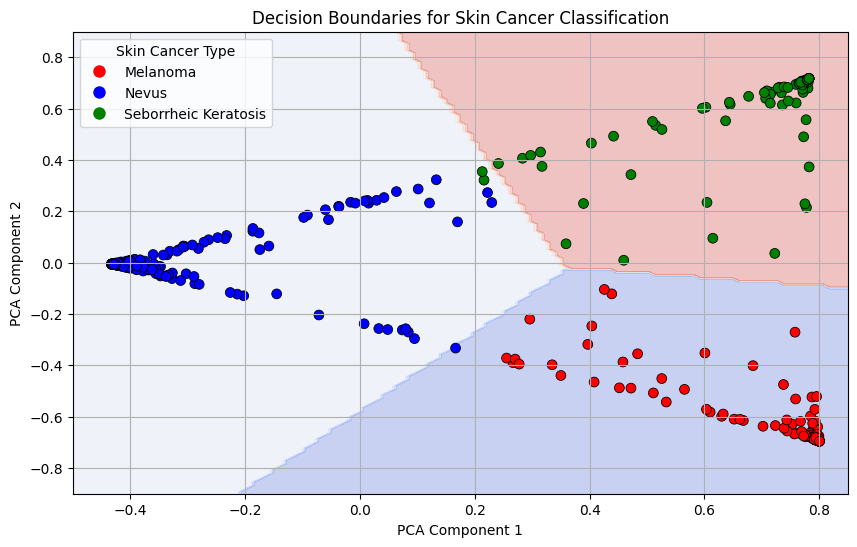

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # Using SVM for decision boundaries

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
test_data_2d = pca.fit_transform(predictions)

# Train a classifier (SVM) on the PCA-transformed data
svm_model = SVC(kernel="linear", C=1.0)  # Linear SVM for decision boundaries
svm_model.fit(test_data_2d, predicted_classes)

# Create a mesh grid for shading the decision regions
x_min, x_max = test_data_2d[:, 0].min() - 0.5, test_data_2d[:, 0].max() + 0.5
y_min, y_max = test_data_2d[:, 1].min() - 0.5, test_data_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict class for each point in the mesh grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color mappings
colors = ['red', 'blue', 'green']
class_names = ['Melanoma', 'Nevus', 'Seborrheic Keratosis']
region_colors = ["red", "blue", "green"]

# Plot decision boundary with shading
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter plot with actual test points
sns.scatterplot(x=test_data_2d[:, 0], y=test_data_2d[:, 1], hue=predicted_classes, palette=colors, edgecolor='k', s=50)

# Improve visualization
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundaries for Skin Cancer Classification")
plt.legend(handles=[plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[i], markersize=10, label=class_names[i]) for i in range(3)], title="Skin Cancer Type", loc="upper left")
plt.xlim(-0.5, 0.85)  
plt.ylim(-0.9, 0.9)   


plt.grid(True)
plt.show()

# Plot Training Accuracy vs Validation Accuracy

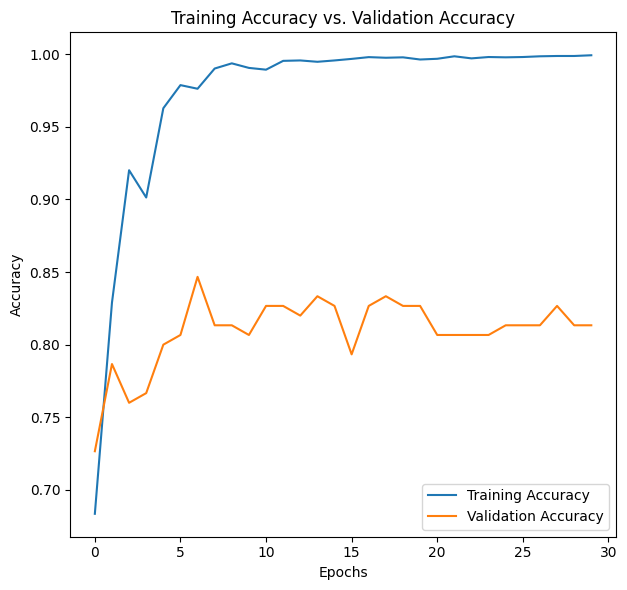

In [20]:
# Get accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training Accuracy vs. Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', linestyle='-')
plt.plot(val_accuracy, label='Validation Accuracy', linestyle='-')
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Training Loss vs Validation Loss

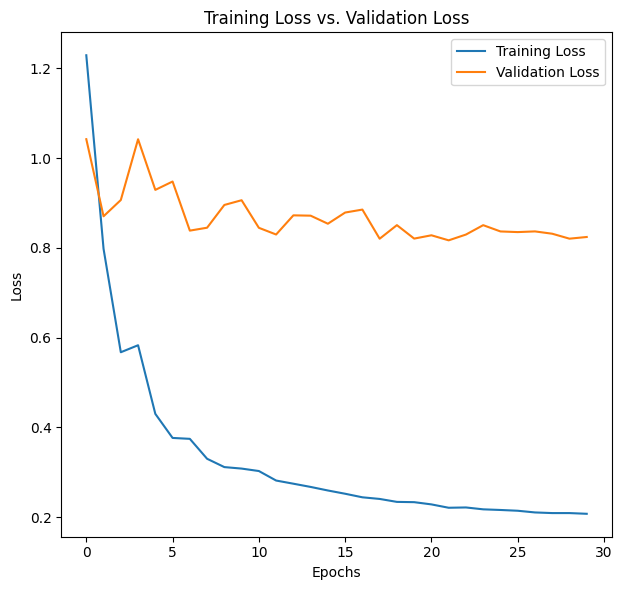

In [21]:
# Get accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training Loss vs. Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', linestyle='-')
plt.plot(val_loss, label='Validation Loss', linestyle='-')
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Confusion Matrix

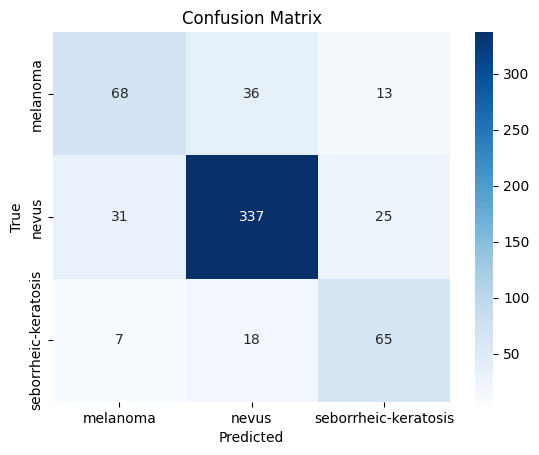

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=class_map.values(), yticklabels=class_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()